### Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader

import timm
from torch import nn
from tqdm import tqdm
from PIL import Image

/home/jerlshin/env_ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configurations

In [2]:
TRAIN_IMG_FOLDER_PATH = './images/train/'
VALID_IMG_FOLDER_PATH = './images/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

In [4]:
# Dynamic Augmentation
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(), # (h, w, c) --> (c, h, w) # pytorch conventions
]) 

valid_augs = T.Compose([
    T.ToTensor()
])

In [5]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

In [6]:
print(f"Total no of examples in trainset: {len(trainset)}")
print(f"Total no of examples in validset: {len(validset)}")

Total no of examples in trainset: 28821
Total no of examples in validset: 7066


In [13]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

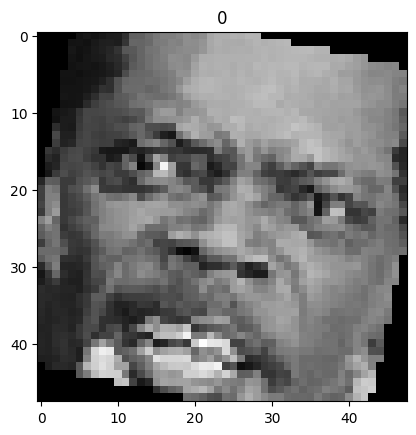

In [14]:
image, label = trainset[2]

plt.imshow(image.permute(1, 2, 0))
plt.title(label)

### Load Dataset into Batches

In [16]:
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(dataset=validset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
print(f"Total no of batches in trainloader: {len(trainloader)}")
print(f"Total no of batches in validloader: {len(validloader)}")

Total no of batches in trainloader: 901
Total no of batches in validloader: 221


In [18]:
for images, labels in trainloader:
    break # break after reading the first batch

images.shape, labels.shape

(torch.Size([32, 3, 48, 48]), torch.Size([32]))

In [20]:
class FaceModel(nn.Module):
    def __init__(self):
        super(FaceModel, self).__init__()
        self.eff_net = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 7)
    def forward(self, images, labels=None):
        logits = self.eff_net(images)
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        return logits

In [22]:
model = FaceModel()
model.to(device=DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

### Train and Eval function

In [23]:
def multiclass_accuracy(y_pred, y_true): # accuracy of predictions for a multi class classification. Tensor with shape y_pred -> (batch_size, num_classes), y_true -> (batch_size, 1)
    top_p, top_class = y_pred.topk(1, dim=1) # to find top k values, k=1, highest value. we are working along the 2nd dim, cols
    # top_p - to predicted probability, top_class - class index
    equals = top_class == y_true.view(*top_class.shape)# reshapes the y_true tensor to match the shape of the top_class shape
    # creates a boolean tensor
    return torch.mean(equals.type(torch.FloatTensor)) # mean of the boolean vector

In [24]:
def train_fn(model, dataloader, optimizer, current_epo):
    model.train() # change to training mode
    total_loss = 0.0
    total_acc = 0.0
    
    # initializes the tqdm progress bar that iterates over the provided data loader, provides visual representation of the training progress
    tk = tqdm(dataloader, desc="EPOCH" + "[TRAIN]" + str(current_epo)+"/"+str(EPOCHS))
    
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        logits, loss = model(images, labels)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)), 'acc' : '%6f' %float(total_acc/(t+1)) })
        
    return total_loss/len(dataloader), total_acc/len(dataloader)


In [31]:
def eval_fn(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_acc = 0.0
    
    tk = tqdm(dataloader, desc="EVAL")
    
    with torch.no_grad():  # Disable gradient computation during evaluation
        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, loss = model(images, labels)

            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)
            tk.set_postfix({'loss': '%6f' % float(total_loss / (t + 1)), 'acc': '%6f' % float(total_acc / (t + 1)) })

    return total_loss / len(dataloader), total_acc / len(dataloader)


### Training Loop

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        best_valid_loss = valid_loss

EVAL: 100%|██████████| 221/221 [00:04<00:00, 51.48it/s, loss=1.058720, acc=0.635855]


### Inference

In [34]:
def view_classify(img, ps):
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
   
    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [36]:
model = FaceModel()
model.load_state_dict(torch.load('best-weights.pt'))
model.eval()
model.to(device=DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 

In [42]:
def preprocess_image(image_path, transformer):
    image = Image.open(image_path)
    preprocessed_image = transformer(image).unsqueeze(0).to(DEVICE)
    return preprocessed_image

def predict_expression(image_path):
    preprocessed_image = preprocess_image(image_path, valid_augs)
    
    model = FaceModel()
    model.load_state_dict(torch.load('best-weights.pt'))
    model.eval()
    model.to(device=DEVICE)
    
    with torch.no_grad():
        logits = model(preprocessed_image)
        prob = torch.softmax(logits, dim=1)
    
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    predicted_class_idx = torch.argmax(prob)
    predicted_class = classes[predicted_class_idx]
    
    return predicted_class

In [43]:
image_path = 'image.jpg'
print(predict_expression(image_path))

disgust
